# IMPORTS


In [1]:
# LIBRARIES


# interactive matplotlib plots
%matplotlib notebook
#%matplotlib inline

# imports
import pydicom as dicom
import numpy as np
import scipy 
import os

import matplotlib.pyplot as plt
import matplotlib

from ipywidgets import interact

import numpy as np

import time



# CLASSES

In [2]:
# CONVERTER CLASS
# Converter Class to convert the images in the CT coordinates to display coordinates
# It can be used to get the new coordinate of a point in the visualization fig
# there is an offset of the center + a flip in the y direction

class coordConverter:
    
    def __init__(self, xorigin, yorigin, pixsizex, pixsizey, dimx, dimy):
        self.xorigin = xorigin
        self.yorigin = yorigin
        self.pixsizex = pixsizex
        self.pixsizey = pixsizey
        self.dimx = dimx
        self.dimy = dimy

    def convertCoord(self, x, y):
        newposx = int(round((x-self.xorigin)/self.pixsizex))
        newposy = int(round((y-self.yorigin)/self.pixsizey))
        return (newposx, newposy)
    
    def converStructList(self, structList):
        newPointList = []
        for i in structList:
            newposx = int(round((i[0]-self.xorigin)/self.pixsizex))
            newposy = int(round((i[1]-self.yorigin)/self.pixsizey))
            newPointList.append((newposx, newposy))
        return newPointList


# FUNCTIONS 

In [3]:
# DISPLAYS THE NAMES OF THE ROIS IN THE STRUCTURE FILE
# @path: directory the file is
# @file: name of the structure file

def dispRoiNames(d):
    
    n = len(d.StructureSetROISequence)
    print('The file contains', n, 'structures:')

    for i in range(n):
        print('  ', i, ':', d.StructureSetROISequence[i].ROIName, '(', 
              len(d.ROIContourSequence[i].ContourSequence), 'slices)')

In [4]:
# RETURNS A LIST OF POINTS CORRESPONDING TO THE STRUCTURE 
# @contourDataset: contour at the selected slice

def getPointList(contourDataset, dispNbPoints = False):
    c1 = contourDataset.ContourData
    nbpoints = int(contourDataset.NumberOfContourPoints) 
    if dispNbPoints: print("Nb of points in the structure on that slice:", nbpoints)

    pointList = []
    for i in range (0,nbpoints):
        x1 = c1[(i*3)]
        y1 = c1[(i*3)+1]
        pointList.append((x1, y1))

    return pointList

In [5]:
# RETURNS A DICTIONARY CONTAINING THE FILENAME CORRESPONDING TO EACH UI
# This method helps to get de filename of the CT slice corresponding to the 
# UI stored in the structure datafile
# @path: folder where all the CT slices are.

def getCTdictionary(path):
    
    # handles `/` missing
    if path[-1] != '/': path += '/'
    
    # gets the list of filenames:
    fpaths = [path + f for f in os.listdir(path) if ('.dcm' in f or '.DCM' in f)]
    
    # reads all files and creates dictionary
    n = 0
    CTdict = {}
    for fpath in fpaths:
        f = dicom.read_file(fpath)
        if ('Modality' in dir(f))and(f.Modality=='CT'):
            CTdict.update({f.SOPInstanceUID : fpath})
            n += 1
            
            
    if n==0: print('No CT file found in this directory.')
    
    return CTdict

# MAIN

In [6]:
# Input parameters:

# DICOM Files (structures, SPECT & CT)
m_structFile = 'imgs/Torso PET Tc99m/CT/RS1.2.752.243.1.1.20200423172207042.2000.88865.dcm'
m_spectFile = 'imgs/Torso PET Tc99m/reconstructed imgs/ACLIN1.col.900f.fr.col.S1.2986626.1_00000.DCM'
m_CTpath = 'imgs/Torso PET Tc99m/CT/'
#m_structFile = 'imgs/test mimou/contours.dcm'
#m_spectFile = 'imgs/test mimou/spect.DCM'
#m_CTpath = 'imgs/test mimou/'

# ROI of interest
m_ROInb = 0

# SPECT Visualization window:
m_SPECTvmin = 0    # absolute value
m_SPECTvmax = 0.3  # *(max-min)+min

m_CTvmin = -100    # absolute value
m_CTvmax = 2000    # absolute value

In [7]:
# GETS THE IMPORTANT INFORMATION FROM THE FILES:

# reads the structure file and display ROI names:
m_struct = dicom.dcmread(m_structFile)
dispRoiNames(m_struct)


# Gets the dictionary UI:CTfilename
m_CTdict = getCTdictionary(m_CTpath)
print('\nDictionary containing UIDs and scan names created')


# Gets SPECT information:
# Reads the CT image corresponding to the slice of interest:
c_data = m_struct.ROIContourSequence[0].ContourSequence[0]
imgID = c_data.ContourImageSequence[0].ReferencedSOPInstanceUID
CTimg = dicom.read_file(m_CTdict[imgID])

m_CTxSpacing, m_CTySpacing = float(CTimg.PixelSpacing[0]), float(CTimg.PixelSpacing[1])
m_CTxOrigin, m_CTyOrigin, CTzOrigin = CTimg.ImagePositionPatient 
m_CTsizeX, m_CTsizeY = CTimg.Rows, CTimg.Columns

print("\nCT Image information:")
print(" -> Image dimension in pixels: (", m_CTsizeX, "x", m_CTsizeY, ")")
print(" -> Pixel dimension in mm: (", m_CTxSpacing, "x", m_CTySpacing, ")")
print(" -> Image Origin in mm: (", m_CTxOrigin, "x", m_CTyOrigin, ",", CTzOrigin, ")\n")


# Reads the SPECT image corresponding to the slice of interest:
SPECTimg = dicom.read_file(m_spectFile)

m_SPECTarray = SPECTimg.pixel_array
m_SPECTxSpacing, m_SPECTySpacing = float(SPECTimg.PixelSpacing[0]), float(SPECTimg.PixelSpacing[1])
m_SPECTzSpacing = SPECTimg[0x0018,0x0050].value
[m_SPECTxOrigin, m_SPECTyOrigin, m_SPECTzOrigin] = SPECTimg[0x0054,0x0022][0][0x0020,0X0032] 
m_SPECTsizeX, m_SPECTsizeY = SPECTimg.Rows, SPECTimg.Columns

print("SPECT Image information:")
print(" -> Image dimension in pixels: (", m_SPECTsizeX, "x", m_SPECTsizeY, ")")
print(" -> Pixel dimension in mm: (", m_SPECTxSpacing, "x", m_SPECTySpacing, "x", m_SPECTzSpacing, ")")
print(" -> Image Origin in mm: (", m_SPECTxOrigin, ",", m_SPECTyOrigin, ",", m_SPECTzOrigin, ")\n")


# Defines the basics of the figure: 
CTgrid_size = (m_CTsizeX, m_CTsizeY)


The file contains 5 structures:
   0 : External ( 384 slices)
   1 : lesion 1 ( 46 slices)
   2 : lesion 2 ( 47 slices)
   3 : lesion 3 ( 41 slices)
   4 : poumons ( 161 slices)

Dictionary containing UIDs and scan names created

CT Image information:
 -> Image dimension in pixels: ( 512 x 512 )
 -> Pixel dimension in mm: ( 0.976562 x 0.976562 )
 -> Image Origin in mm: ( -250.000 x -250.000 , -95.000 )

SPECT Image information:
 -> Image dimension in pixels: ( 128 x 128 )
 -> Pixel dimension in mm: ( 4.418156 x 4.418156 x 4.41816 )
 -> Image Origin in mm: ( -282.952906 , -278.352906 , 280.552906 )



In [8]:
# Precomputing for display:
# Stores the image matrices and structures in lists

m_nbSlices = len(m_struct.ROIContourSequence[m_ROInb].ContourSequence)
cconv = coordConverter(m_CTxOrigin, m_CTyOrigin, m_CTxSpacing, m_CTySpacing, m_CTsizeX, m_CTsizeY)

m_CTmatrix = []
m_CTpointList = {}
for i in range(m_nbSlices):
    cdata = m_struct.ROIContourSequence[m_ROInb].ContourSequence[i]
    
    imgID = cdata.ContourImageSequence[0].ReferencedSOPInstanceUID
    m_CTmatrix.append(dicom.read_file(m_CTdict[imgID]).pixel_array)
    
    pointList = getPointList(cdata, dispNbPoints = False)
    m_CTpointList.update(cconv.converStructList(pointList))
    
    

<IPython.core.display.Javascript object>


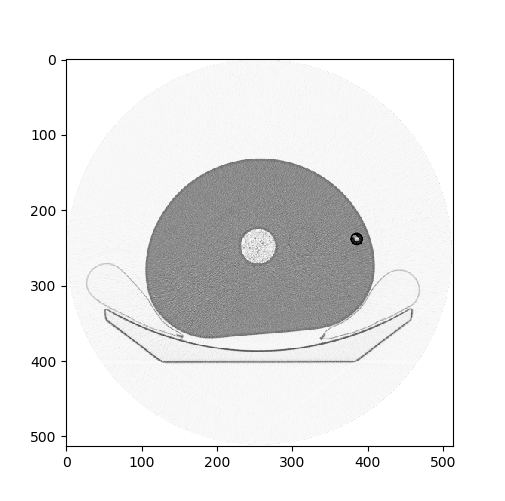

interactive(children=(IntSlider(value=191, description='x', max=383), Output()), _dom_classes=('widget-interac…

<function __main__.f(x)>

In [9]:
# Display function:
def f(x):
    imgID = cdata.ContourImageSequence[0].ReferencedSOPInstanceUID
    CTimg = dicom.read_file(m_CTdict[imgID])
    dispImg.set_data(m_CTmatrix[x])
    fig.canvas.draw()
    
#    polygoneCT = plt.Polygon(m_CTpointList[x], fill=False, color = "red", linewidth=2)
#    ax1.add_patch(polygoneCT)


# Visualization of the graph and the slider to scroll the slides:    
fig, (ax1) = plt.subplots(1, figsize=(8,8))
ax1.set_xlim(-0.5, m_CTsizeX+0.5)
ax1.set_ylim(m_CTsizeY+0.5, -0.5)

dispImg = ax1.imshow(m_CTmatrix[int(m_nbSlices/2)], cmap="Greys", interpolation="nearest", 
            vmin = m_CTvmin, vmax = m_CTvmax)


interact(f, x=(0, m_nbSlices-1, 1))